In [41]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pyvista as pv
import seaborn as sns
import pandas as pd
import numpy as np
import os
import glob

---
## Chargement des Données

In [42]:
#DATASET_NAME = 'RF_FULGUR_M_MESH'
DATASET_NAME = 'RF_FULGUR_FULL_M'

PARTICLES_DIR = f'./OUTPUT/{DATASET_NAME}/{DATASET_NAME}_default_particles'
OUTPUT_DIR = f'./OUTPUT/{DATASET_NAME}/PCA_results'

In [43]:
def get_particles(particles_dir, type='local'):
    particles = []
    names = []
    for filename in os.listdir(particles_dir):
        if filename.endswith(type + ".particles"):
            filepath = os.path.join(particles_dir, filename)
            try:
                data = np.loadtxt(filepath)
                particles.append(data)
                names.append(os.path.splitext(filename)[0])  # Keep the file name without extension
            except Exception as e:
                print(f"Error reading file {filename}: {e}")
    if particles:
        return np.array(particles), names
    return None, None

particles, shape_names = get_particles(PARTICLES_DIR, type="world")
print(particles.shape)
#print(names)

(76, 128, 3)


#### Affichage des particules

In [44]:
pv.global_theme.jupyter_backend = None
pv.global_theme.notebook = False

def plot_particles_with_pyvista(particles, index=0):
    if index >= len(particles):
        print(f"Index {index} out of bounds for particles array of size {len(particles)}")
        return
    plotter = pv.Plotter(window_size=(800, 600))
    plotter.set_background("white")
    plotter.add_points(particles[index], color='red', point_size=5, render_points_as_spheres=True)
    plotter.show()

#plot_particles_with_pyvista(particles, index=0)

In [45]:
# Flatten (n_shapes, n_points*3) => So shape is (n, d)
particles_flat = particles.reshape(particles.shape[0], -1)
n, d = particles_flat.shape
print(n, d)

76 384


---
## Calcul de l'ACP

In [53]:
pca = PCA(n_components=n - 1 -65)
pca.fit(particles_flat)

eigenvectors = pca.components_      # Vecteurs propres
eigenvalues = pca.explained_variance_  # Valeurs propres
explained_variance_ratios = pca.explained_variance_ratio_

print(f"{len(eigenvectors)=}")

len(eigenvectors)=10


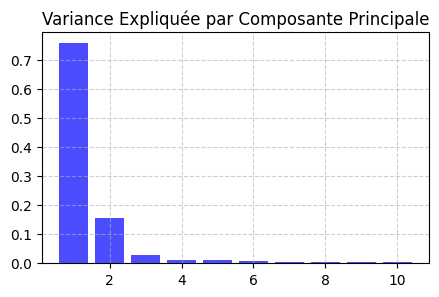

In [54]:
# Plot individual explained variance ratios
plt.figure(figsize=(5, 3))
plt.bar(range(1, len(explained_variance_ratios) + 1), explained_variance_ratios, alpha=0.7, color='b')
plt.title('Variance Expliquée par Composante Principale')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

#for i, var in enumerate(pca.explained_variance_ratio_):
#    print(f'PC{i+1}: {var*100:.2f}% variance explained')

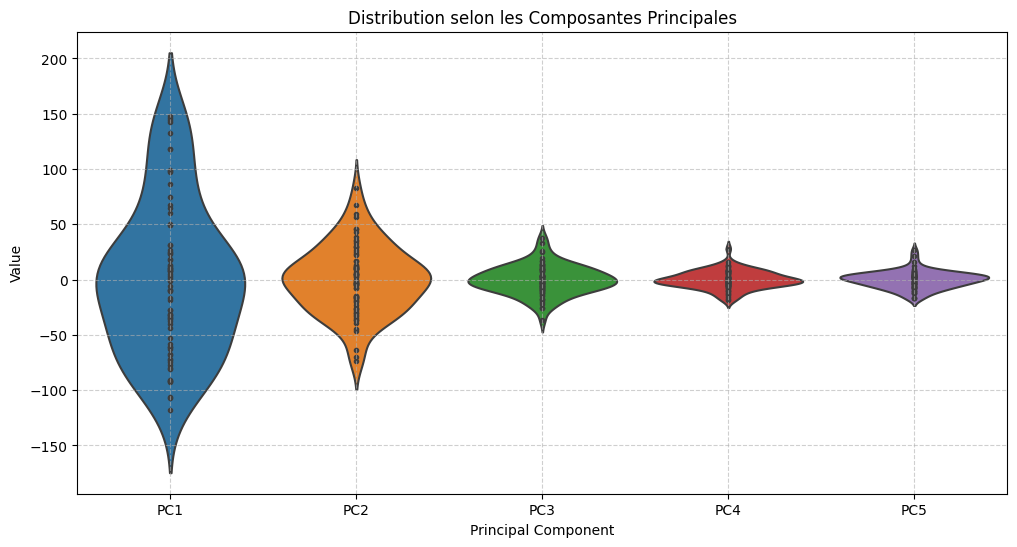

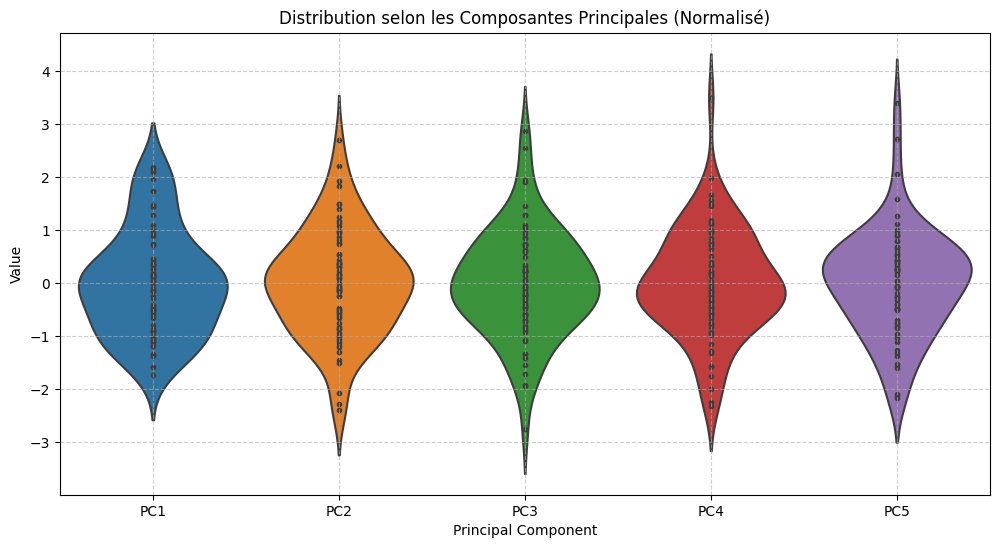

In [55]:
components = pca.transform(particles_flat)

N_COMP = 5

# Normalized components
normalized_components = components[:, :N_COMP] / np.sqrt(pca.explained_variance_[:N_COMP])

# Unscaled DataFrame for plotting
unscaled_pc_df = pd.DataFrame(components[:, :N_COMP], columns=[f'PC{i+1}' for i in range(N_COMP)])
unscaled_pc_df_melted = unscaled_pc_df.melt(var_name='Principal Component', value_name='Value')

# Scaled DataFrame for plotting
scaled_pc_df = pd.DataFrame(normalized_components, columns=[f'PC{i+1}' for i in range(N_COMP)])
scaled_pc_df_melted = scaled_pc_df.melt(var_name='Principal Component', value_name='Value')

# Plot Unscaled Data
plt.figure(figsize=(12, 6))
sns.violinplot(data=unscaled_pc_df_melted, x='Principal Component', y='Value', inner="point", scale="width")
plt.title('Distribution selon les Composantes Principales')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Plot Scaled Data
plt.figure(figsize=(12, 6))
sns.violinplot(data=scaled_pc_df_melted, x='Principal Component', y='Value', inner="point", scale="width")
plt.title('Distribution selon les Composantes Principales (Normalisé)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

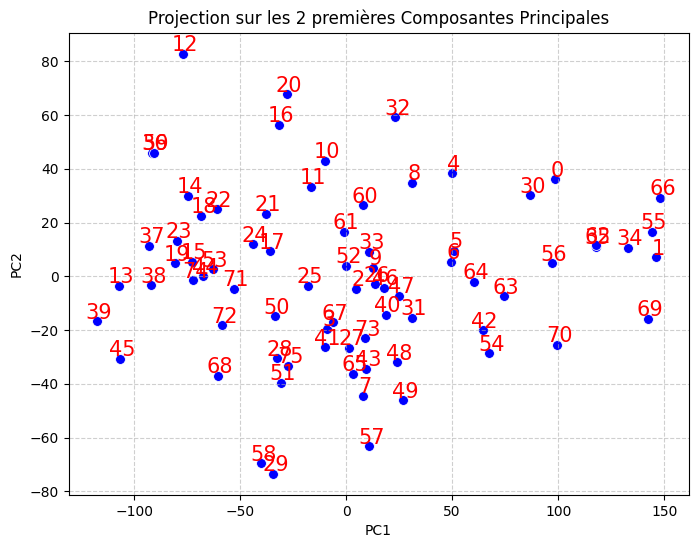

In [56]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=components[:, 0], y=components[:, 1], s=50, color="b")

# Add labels for each point
for i, (x, y) in enumerate(zip(components[:, 0], components[:, 1])):
    plt.text(x + 1, y + 1, str(i), fontsize=15, color="red", ha="center")

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Projection sur les 2 premières Composantes Principales')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


In [57]:
# Pour reconnaître les muscles affichés

"""
# Dans RF_FULGUR (28 muscles), ces muscles là sont les muscles gauche
print(shape_names[0])
print(shape_names[7])
print(shape_names[9])
print(shape_names[15])
print(shape_names[21])
"""
"""
# Dans RF_FULGUR (28 muscles), ces muscles là sont des muscles dans les bords du plot
print(shape_names[24])
print(shape_names[9])
print(shape_names[4])
print(shape_names[5])
"""
None

---
## Génération des fichiers

In [58]:
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# Save eigenvalues
with open(os.path.join(OUTPUT_DIR, 'eigenvalues.eval'), 'w') as f:
    for i, eigenvalue in enumerate(eigenvalues):
        f.write(f'{eigenvalue}\n')

# Save eigenvectors
eigenvectors_reshaped = eigenvectors.reshape(eigenvectors.shape[0], -1, 3)
for i, eigenvector in enumerate(eigenvectors_reshaped):
    filename = os.path.join(OUTPUT_DIR, f'eigenvector_{i+1}.eig')
    np.savetxt(filename, eigenvector, fmt='%f')
    
print("PCA Exported !")

print(f"{len(eigenvectors_reshaped)}")

PCA Exported !
10
